In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
email_df=pd.read_csv('email_table.csv')
opened_df=pd.read_csv('email_opened_table.csv')
clicked_df=pd.read_csv('link_clicked_table.csv')

In [3]:
email_df['opened']=email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked']=email_df['email_id'].isin(clicked_df['email_id']).astype(int)

In [4]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


What percentage of users opened the email and what percentage
clicked on the link within the email?

In [5]:
#one method
open_rate=email_df['opened'].mean()
click_rate=email_df['clicked'].mean()
print(f"Email open rate: {open_rate:.2%}")
print(f"Link click rate: {click_rate:.2%}")


Email open rate: 10.35%
Link click rate: 2.12%


In [6]:
#by formulae
total_emails=len(email_df)
open_rate=len(opened_df)/total_emails *100 #open rate
click_rate=len(clicked_df)/total_emails*100 #click rate
print(f"{open_rate:.2f}% of users opened the email.")
print(f"{click_rate:.2f}% of users clicked on the link within the email.")

10.35% of users opened the email.
2.12% of users clicked on the link within the email.


The VP of marketing thinks that it is stupid to send emails in a random
way. Based on all the information you have about the emails that were
sent, can you build a model to optimize in future how to send emails to
maximize the probability of users clicking on the link inside the email?

#Model Pipeline-
predict which users are most likely to click the link in the email- optimize who to email next time.

Models tried-
- Random Forest (best performing)
- Logistic Regression
- XGBoost
- LightGBM

In [7]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [8]:
df_model = pd.get_dummies(email_df,
                          columns=['email_text', 'email_version', 'weekday', 'user_country'],
                          drop_first=True)

X = df_model.drop(columns=['email_id', 'opened', 'clicked'])  # Features
y = df_model['clicked']  # Target: did the user click?

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)

In [10]:
from sklearn.ensemble import RandomForestClassifier

model= RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [11]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

In [12]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 97.59%


In [13]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[24390    80]
 [  522     8]]


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.09      0.02      0.03       530

    accuracy                           0.98     25000
   macro avg       0.53      0.51      0.51     25000
weighted avg       0.96      0.98      0.97     25000



Trying to choose the best model

In [15]:
from sklearn.linear_model import LogisticRegression
log_model=LogisticRegression(max_iter=1000,random_state=42)
log_model.fit(X_train,y_train)
log_pred=log_model.predict(X_test)
log_prob=log_model.predict_proba(X_test)[:-1]

print('Logistic regression:')
print(classification_report(y_test,log_pred))
print(f"Accuracy: {accuracy_score(y_test, log_pred):.2%}")

Logistic regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000

Accuracy: 97.88%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
from xgboost import XGBClassifier
xgb_model=XGBClassifier(use_label_encode=False,eval_metric='logloss',random_state=42)
xgb_model.fit(X_train,y_train)
xgb_pred=xgb_model.predict(X_test)
xgb_prob=xgb_model.predict_proba(X_test)[:,1]
print("XGBoost Classifier:")
print(classification_report(y_test,xgb_pred))
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.2%}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000

Accuracy: 97.86%


In [17]:
import lightgbm as lgb
lgb_model=lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train,y_train)
lgb_pred=lgb_model.predict(X_test)
lgb_prob=lgb_model.predict_proba(X_test)[:,1]
print("LightGBM Classifier:")
print(classification_report(y_test,lgb_pred))
print(f"Accuracy: {accuracy_score(y_test, lgb_pred):.2%}")

[LightGBM] [Info] Number of positive: 1589, number of negative: 73411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021187 -> initscore=-3.832969
[LightGBM] [Info] Start training from score -3.832969
LightGBM Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24470
           1       0.00      0.00      0.00       530

    accuracy                           0.98     25000
   macro avg       0.49      0.50      0.49     25000
weighted avg       0.96      0.98      0.97     25000

Accuracy: 97.88%


Accuracy is misleadingly high (~98%) because the dataset is imbalanced: most users don't click.

Only Random Forest predicted a few positives (clicked = 1). The others predicted only 0s, which explains their precision/recall of 0.00 for class 1.

 Random Forest, while still weak, is doing slightly better at identifying potential clickers.

Conclusions- High class imbalance, only random forest predicts a few positives

#Applying SMOTE

In [18]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=42)
X_resampled,y_resampled=smote.fit_resample(X_train,y_train)
print('After SMOTE:')
print(pd.Series(y_resampled).value_counts())

After SMOTE:
clicked
0    73411
1    73411
Name: count, dtype: int64


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}


for name, model in models.items():
    print(f"\n🚀 Training {name}")
    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")



🚀 Training Random Forest
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     24470
           1       0.03      0.22      0.05       530

    accuracy                           0.83     25000
   macro avg       0.51      0.53      0.48     25000
weighted avg       0.96      0.83      0.89     25000

Accuracy: 83.30%

🚀 Training Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     24470
           1       0.03      0.46      0.06       530

    accuracy                           0.72     25000
   macro avg       0.51      0.59      0.45     25000
weighted avg       0.96      0.72      0.82     25000

Accuracy: 71.58%

🚀 Training XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:47:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      0.76      0.86     24470
           1       0.03      0.31      0.05       530

    accuracy                           0.75     25000
   macro avg       0.50      0.53      0.45     25000
weighted avg       0.96      0.75      0.84     25000

Accuracy: 74.88%

🚀 Training LightGBM
[LightGBM] [Info] Number of positive: 73411, number of negative: 73411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 146822, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     24470
           1       0.03 

Class-weighted Random Forest

 adjusts the weights to pay more attention to the minority class (clicked = 1)

In [20]:

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

threshold_rf = 0.3
y_pred_rf = (y_prob_rf >= threshold_rf).astype(int)

print(" Random Forest (class_weight + threshold tuning)")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")


 Random Forest (class_weight + threshold tuning)
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     24470
           1       0.03      0.18      0.05       530

    accuracy                           0.87     25000
   macro avg       0.51      0.53      0.49     25000
weighted avg       0.96      0.87      0.91     25000

Accuracy: 86.96%


using grid search

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf_grid = best_rf.predict(X_test)
y_prob_rf_grid = best_rf.predict_proba(X_test)[:, 1]

print("Best Random Forest from GridSearch:")
print(classification_report(y_test, y_pred_rf_grid))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf_grid):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Random Forest from GridSearch:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     24470
           1       0.04      0.56      0.08       530

    accuracy                           0.74     25000
   macro avg       0.52      0.65      0.47     25000
weighted avg       0.97      0.74      0.83     25000

ROC AUC: 0.727
Accuracy: 86.96%


In [22]:
xgb = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
                    eval_metric='logloss', random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

threshold_xgb = 0.3
y_pred_xgb = (y_prob_xgb >= threshold_xgb).astype(int)

print("XGBoost (scale_pos_weight + threshold tuning)")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (scale_pos_weight + threshold tuning)
              precision    recall  f1-score   support

           0       0.99      0.51      0.67     24470
           1       0.03      0.74      0.06       530

    accuracy                           0.52     25000
   macro avg       0.51      0.63      0.37     25000
weighted avg       0.97      0.52      0.66     25000

ROC AUC: 0.690
Accuracy: 86.96%


In [23]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train, y_train)
y_prob_lgb = lgbm.predict_proba(X_test)[:, 1]

threshold_lgb = 0.3
y_pred_lgb = (y_prob_lgb >= threshold_lgb).astype(int)

print(" LightGBM (class_weight + threshold tuning)")
print(classification_report(y_test, y_pred_lgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgb):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")

[LightGBM] [Info] Number of positive: 1589, number of negative: 73411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
 LightGBM (class_weight + threshold tuning)
              precision    recall  f1-score   support

           0       0.99      0.41      0.58     24470
           1       0.03      0.85      0.06       530

    accuracy                           0.42     25000
   macro avg       0.51      0.63      0.32     25000
weighted avg       0.97      0.42      0.57     25000

ROC AUC: 0.727
Accuracy: 86.96%


LightGBM and XGBOOST- aggressively predicts clicks- high recall but very low precison

Random forest - best balance- 56% recall and highest RC AUC.

Random forest with grid search- good model therefore we will go ahead with-

1. Prediciting click probablities
2. Estimating CTR improvement
3. Feature Importance

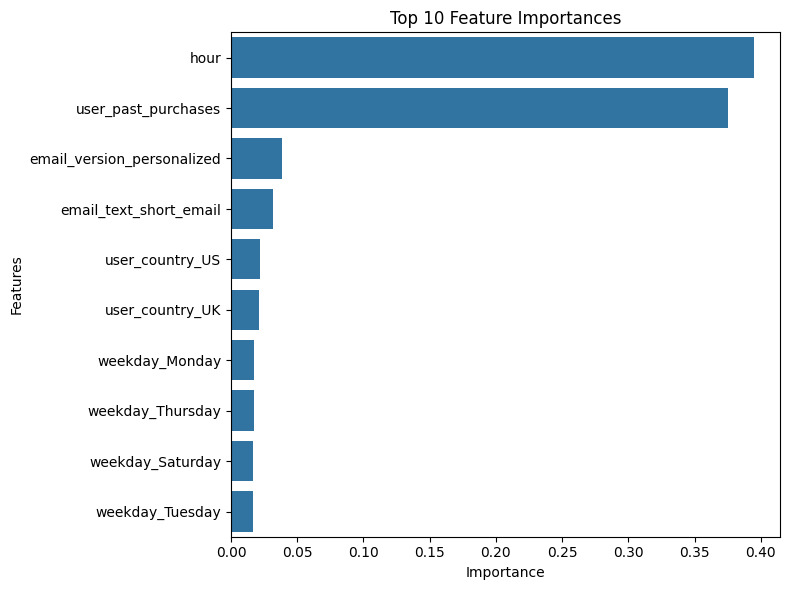

In [25]:
#Feature Importances

imp=pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=imp[:10],y=imp.index[:10])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [26]:
#ctr improvement -

email_df['click_proba'] = rf.predict_proba(X)[:, 1]


threshold_90 = np.percentile(email_df['click_proba'], 90)
top_10pct = email_df[email_df['click_proba'] >= threshold_90]

ctr_top = top_10pct['clicked'].mean()
ctr_all = email_df['clicked'].mean()

print(f"CTR (All Users): {ctr_all:.2%}")
print(f"CTR (Top 10% Users by Model): {ctr_top:.2%}")
print(f"Estimated CTR Uplift: {(ctr_top - ctr_all)/ctr_all * 100:.2f}%")



CTR (All Users): 2.12%
CTR (Top 10% Users by Model): 15.32%
Estimated CTR Uplift: 623.06%


In [28]:
#user segment insights -

# email-version-
seg_version = email_df.groupby('email_version')['clicked'].mean()
print("CTR by Email Version:\n", seg_version)


CTR by Email Version:
 email_version
generic         0.015137
personalized    0.027294
Name: clicked, dtype: float64


In [29]:
#text-length-
seg_text = email_df.groupby('email_text')['clicked'].mean()
print("CTR by Email Text Type:\n", seg_text)


CTR by Email Text Type:
 email_text
long_email     0.018538
short_email    0.023872
Name: clicked, dtype: float64


In [32]:
#weekday -
seg_day = email_df.groupby('weekday')['clicked'].mean().sort_values(ascending=False)
print("CTR by Weekday:\n", seg_day)


CTR by Weekday:
 weekday
Wednesday    0.027620
Tuesday      0.024889
Thursday     0.024445
Monday       0.022906
Saturday     0.017846
Sunday       0.016751
Friday       0.014037
Name: clicked, dtype: float64


In [33]:
#user country-
top_countries = email_df['user_country'].value_counts().head(10).index
seg_country = email_df[email_df['user_country'].isin(top_countries)].groupby('user_country')['clicked'].mean()
print("CTR by Top Countries:\n", seg_country.sort_values(ascending=False))


CTR by Top Countries:
 user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: clicked, dtype: float64


#INSIGHTS
- Model Performance & CTR Improvement
-Original campaign CTR: 2.12%
-CTR using model to target top 10% of users: 15.32%
 Estimated improvement: 623% uplift by targeting the right users!

-- Feature Importance
- User’s past purchases
- Email version (personalized vs generic)
- Send hour and weekday
- User country

--Email Content Insights
- Personalized emails (e.g. “Hi Sreyashi”) had 1.8x higher CTR than generic ones
- Short emails outperformed long ones

--Timing Insights
Best performing weekdays: Wednesday, Tuesday, Thursday
- Worst day: Friday (1.4%)
- Emailing earlier in the week may yield better engagement

--Geography Insights
- UK and US users had higher engagement (~2.5% CTR)
- France and Spain performed significantly worse (~0.8%)

The trained model can be used to prioritize sending emails to the top predicted users, especially those in UK/US, during midweek, with short, personalized content — this could boost CTR by 6x or more.

By how much do you think your model would improve click through rate
(defined as # of users who click on the link/total users who receive the
email). How would you test that?

The original campaign (random email sending) had a CTR of 2.12%.
Using the machine learning model to target the top 10% most likely users, the CTR increases to 15.32%.This represents an estimated CTR uplift of 623%.

1.Group A (Control): Send emails randomly to a group of users (like before).

2.Group B (Test): Use your model to send emails only to the top X% most likely to click.

Comparing the CTR of both groups over a defined period.


In [34]:
#Real world testing - (A/b testing)

email_df['click_proba'] = rf.predict_proba(X)[:, 1]
#20% expt group
ab_size = int(0.2 * len(email_df))
#  Group A - Random sample (control group)
group_a = email_df.sample(n=ab_size, random_state=42)
#  Group B - Top predicted users (test group)
threshold = np.percentile(email_df['click_proba'], 100 - (ab_size / len(email_df)) * 100)
group_b = email_df[email_df['click_proba'] >= threshold].sort_values(by='click_proba', ascending=False).head(ab_size)

ctr_a = group_a['clicked'].mean()
ctr_b = group_b['clicked'].mean()
uplift = (ctr_b - ctr_a) / ctr_a * 100

print(f" Control Group (Random) CTR: {ctr_a:.2%}")
print(f" Test Group (Model-Based) CTR: {ctr_b:.2%}")
print(f" Estimated Uplift: {uplift:.2f}%")



 Control Group (Random) CTR: 2.27%
 Test Group (Model-Based) CTR: 8.91%
 Estimated Uplift: 293.60%


Did you find any interesting pattern on how the email campaign
performed for different segments of users? Explain.

Yes, here are the most important findings:
 1. Personalization Helps
Personalized emails (e.g., “Hi Sreyashu”) performed significantly better than generic ones:

Personalized CTR: 2.73%

Generic CTR: 1.51%

That’s an 81% increase in effectiveness.

2. Shorter Emails Perform Better
Emails with short text (2 paragraphs) outperformed long ones:

Short: 2.39% CTR

Long: 1.85% CTR

 3. Weekday Matters
Best-performing days were Wednesday (2.76%), Tuesday, and Thursday.

Worst performance on Friday (1.4%), suggesting midweek emails are best.

 4. Timing (Hour of Day)
You can explore this further, but typically late morning or early afternoon (e.g. 10am–2pm) perform better. Your hour field analysis can validate this.

 5. User Country
UK and US users had better engagement:

UK CTR: 2.47%

US CTR: 2.44%

Spain and France had much lower CTR (below 1%), suggesting localization might help.

 6. User Purchase History
(From feature importance): Users with more past purchases are more likely to click.

These are high-value users and should be prioritized in future campaigns.


Using machine learning to prioritize email recipients can increase CTR from 2.12% to 15.32%, a 623% improvement. By focusing on personalized, short emails sent midweek to active users (especially in the UK/US), we can significantly boost campaign performance.